In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold as kfold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression as logi
from sklearn import metrics
from sklearn.preprocessing import scale

In [2]:
train_data = pd.read_csv("train_ctrUa4K.csv")
test_data = pd.read_csv("test_lAUu6dG.csv")
test_ID = test_data['Loan_ID']  #Will need it during submission which requires the Loan_ID
#train_data.info()
#test_data.info()
#train_data.head()

In [3]:
#As Loan ID helps in no way to approve or deny a loan application
train_data = train_data.drop('Loan_ID', axis = 'columns')
test_data = test_data.drop('Loan_ID', axis = 1)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64


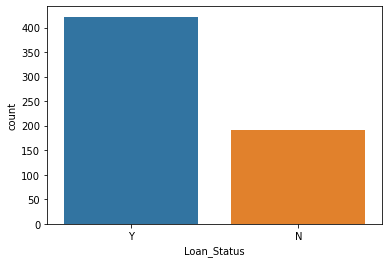

In [4]:
#Lets check the skewness of the target variable - Loan_Status
print(train_data['Loan_Status'].value_counts(normalize=True))
countplot = sns.countplot(train_data['Loan_Status'])

#### As it can be seen, we have a skew of about 2:1 which is reasonable

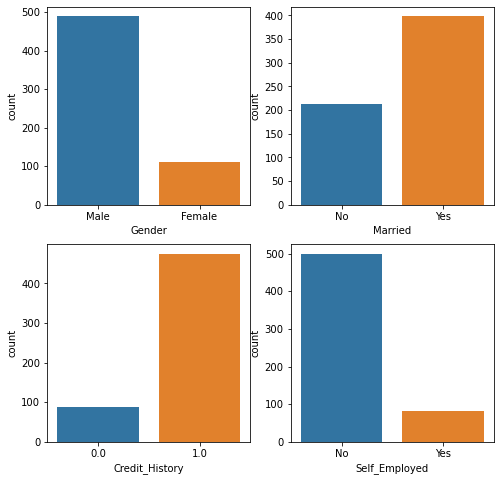

In [5]:
#Now let us analyse various features given to us
#Categorical Variables - 2 Categories
f, axes = plt.subplots(2, 2, figsize = (8,8))
sns.countplot(x = 'Gender', ax = axes[0, 0], data = train_data)
sns.countplot(x = 'Married', ax = axes[0, 1], data = train_data)
sns.countplot(x = 'Credit_History', ax = axes[1, 0], data = train_data)
sns.countplot(x = 'Self_Employed', ax = axes[1, 1], data = train_data)

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


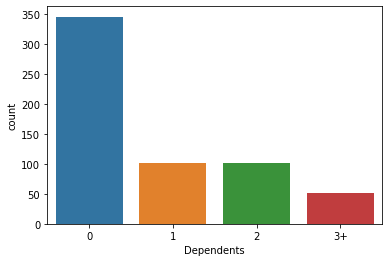

Graduate        480
Not Graduate    134
Name: Education, dtype: int64


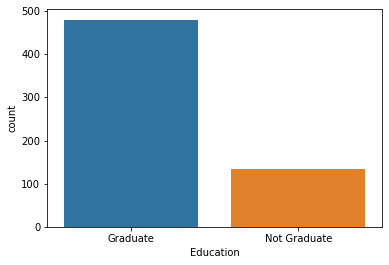

Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


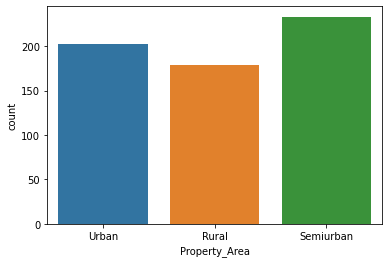

In [6]:
#Other Category Variables
print(train_data['Dependents'].value_counts())
sns.countplot(x = 'Dependents', data = train_data)
plt.show()
print(train_data['Education'].value_counts())
sns.countplot(x = 'Education', data = train_data)
plt.show()
print(train_data['Property_Area'].value_counts())
sns.countplot(x = 'Property_Area', data = train_data)
plt.show()

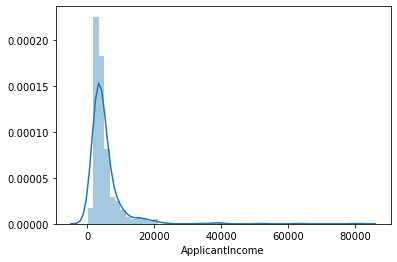

In [7]:
#Let us look at the distribution of Applicant Income
sns.distplot(train_data['ApplicantIncome'])

#### As it can be seen, the income data is right-skewed meaning there are very high valued outliers causing this shift

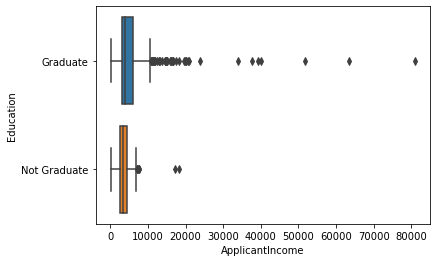

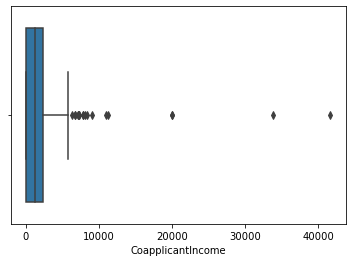

In [8]:
#Lets plot discriminate the same based on education and also, the distribution of Co-Applicant Income using BoxPlot
sns.boxplot(x = 'ApplicantIncome', y = 'Education', data = train_data)
plt.show()
sns.boxplot(x = 'CoapplicantIncome', data = train_data)
plt.show()

### As can be expected, graduates have higher incomes than the non-graduate counterpart and these high incomes are seen as outliers there

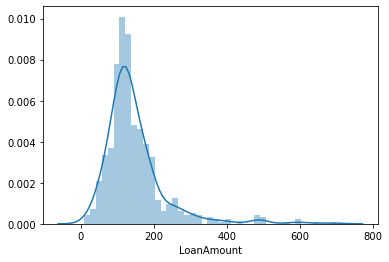

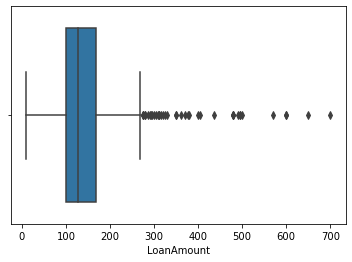

In [9]:
#Now let us look at the distribution of loan amount requested
d = sns.distplot(train_data['LoanAmount'])
plt.show()
b = sns.boxplot(train_data['LoanAmount'])

## Now let us analyze the correlation between the input features and the loan status

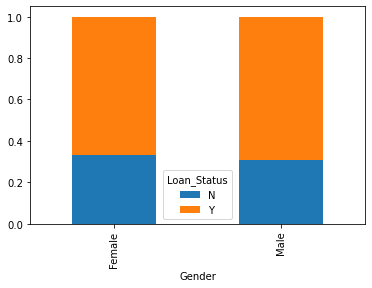

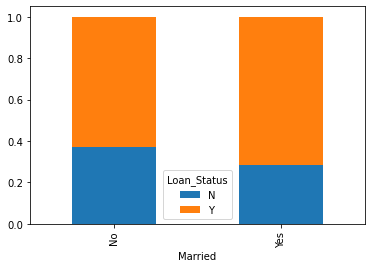

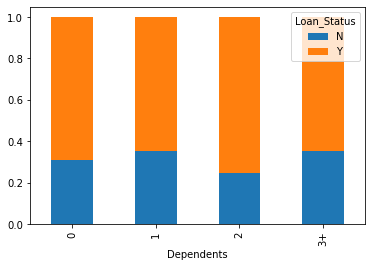

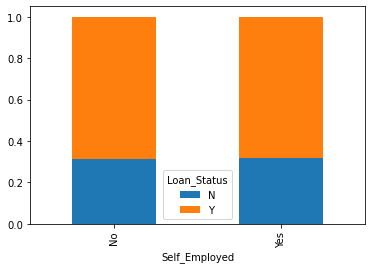

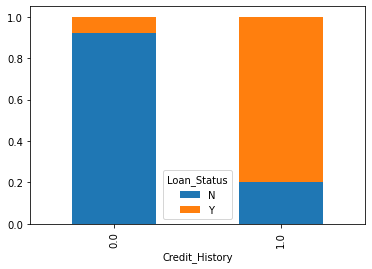

In [10]:
Gend = pd.crosstab(train_data['Gender'], train_data['Loan_Status'])
Gend.div(Gend.sum(1).astype(float), axis = 0).plot.bar(stacked = True)  ##Note to Self: NEED TO LEARN ABOUT THIS FUNCTION
Marr = pd.crosstab(train_data['Married'], train_data['Loan_Status'])
Marr.div(Marr.sum(1).astype(float), axis = 0).plot.bar(stacked = True)
Deps = pd.crosstab(train_data['Dependents'], train_data['Loan_Status'])
Deps.div(Deps.sum(1).astype(float), axis = 0).plot.bar(stacked = True)
SelfE = pd.crosstab(train_data['Self_Employed'], train_data['Loan_Status'])
SelfE.div(SelfE.sum(1).astype(float), axis = 0).plot.bar(stacked = True)

CreditH = pd.crosstab(train_data['Credit_History'], train_data['Loan_Status'])
CreditH.div(CreditH.sum(1).astype(float), axis = 0).plot.bar(stacked = True)

### Insights:
#### 1. Both Gender got comparable ratio of loan approval
#### 2. Married applicants got slightly more approval than the unmarried
#### 3. Dependents has no trend relating to loan approval. One and Three+ dependent have similar loan approval ratio
#### 4. Self-Employed Status has no impact on loan approval
#### 5. People with credit history had significantly more approvals than those without a history

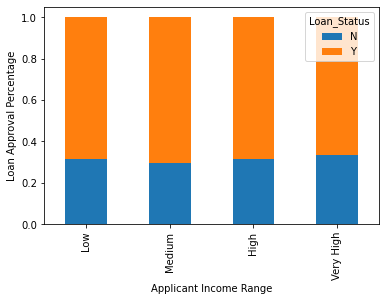

In [11]:
#Lets check with Applicant and Co-Applicant Incomes
bins = [0, 2500, 4000, 6000, 81000]
groups = ['Low', 'Medium', 'High', 'Very High']
train_data['Income_Bin'] = pd.cut(train_data['ApplicantIncome'], bins, labels = groups)
Inc_bin = pd.crosstab(train_data['Income_Bin'], train_data['Loan_Status'])
Inc_bin.div(Inc_bin.sum(1).astype(float), axis = 0).plot.bar(stacked = True)
plt.xlabel('Applicant Income Range')
plt.ylabel('Loan Approval Percentage')
plt.show()

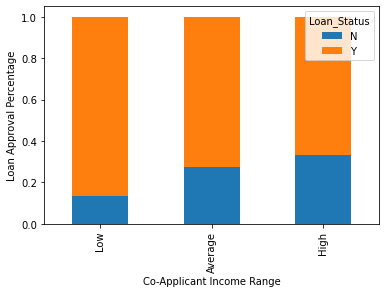

In [12]:
bins = [0, 1000, 3000, 42000]
groups = ['Low', 'Average', 'High']
train_data['Coapplicant_Bin'] = pd.cut(train_data['CoapplicantIncome'], bins, labels = groups)
Inc_bin = pd.crosstab(train_data['Coapplicant_Bin'], train_data['Loan_Status'])
Inc_bin.div(Inc_bin.sum(1).astype(float), axis = 0).plot.bar(stacked = True)
plt.xlabel('Co-Applicant Income Range')
plt.ylabel('Loan Approval Percentage')
plt.show()

### That does not look right! Co applicant with low income improve the chances of getting approval?
### This could be due to the fact that there are many applicants without a co-applicant and thus, their income value is zero who lie in the 'Low' bin and not impacting the loan approval at all

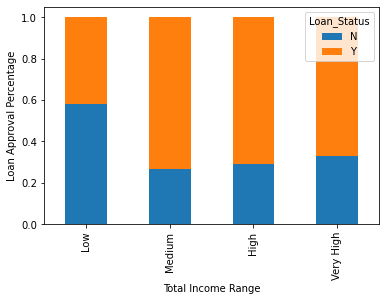

In [13]:
#Now let us look at the total income to resolve this ambiguity
train_data['Total_Income'] = train_data['ApplicantIncome'] + train_data['CoapplicantIncome']
bins = [0, 2500, 4000, 6000, 81000]
groups = ['Low', 'Medium', 'High', 'Very High']
train_data['Income_Bin'] = pd.cut(train_data['Total_Income'], bins, labels = groups)
Inc_bin = pd.crosstab(train_data['Income_Bin'], train_data['Loan_Status'])
Inc_bin.div(Inc_bin.sum(1).astype(float), axis = 0).plot.bar(stacked = True)
plt.xlabel('Total Income Range')
plt.ylabel('Loan Approval Percentage')
plt.show()

### Now that makes sense. Higher income gets higher proportion of loan approval!

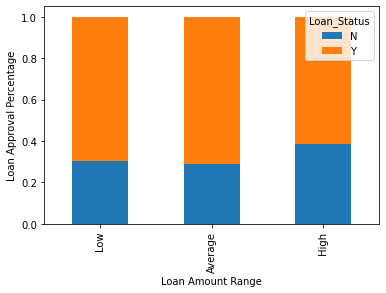

In [14]:
#Now, let us visualize the Loan Amount
bins = [0, 100, 200, 700]
groups = ['Low', 'Average', 'High']
train_data['Loan_Bin'] = pd.cut(train_data['LoanAmount'], bins, labels = groups)
LoanAmt_Bin = pd.crosstab(train_data['Loan_Bin'], train_data['Loan_Status'])
LoanAmt_Bin.div(LoanAmt_Bin.sum(1).astype(float), axis = 0).plot.bar(stacked = True)
plt.xlabel('Loan Amount Range')
plt.ylabel('Loan Approval Percentage')
plt.show()

### People who requested for lower loan amounts got higher approval for their applications

In [15]:
#Now that the analysis is done, let us drop the bins we created
train_data = train_data.drop(['Income_Bin', 'Coapplicant_Bin', 'Total_Income', 'Loan_Bin'], axis = 1)
print(train_data.columns)

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')


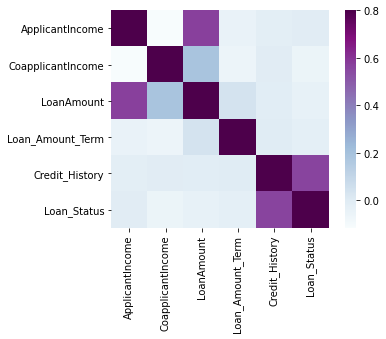

In [16]:
#Now let us analyze the correlation between the input features
#First, we will have to convert some labelled feature data into numerical data
train_data['Dependents'].replace('3+', 3, inplace = True)
test_data['Dependents'].replace('3+', 3, inplace = True)
train_data['Loan_Status'].replace('Y', 1, inplace = True)
train_data['Loan_Status'].replace('N', 0, inplace = True)

matrix = train_data.corr()
sns.heatmap(matrix, vmax = 0.8, square = True, cmap = 'BuPu')

### Correlation exists between LoanAmount and ApplicantIncome
### Between Loan_Status and Credit_History
### Some degree between LoanAmount and CoapplicantIncome

In [17]:
#Now that we have performed all the analysis, check the columns for null values and impute accordingly
print("TRAINING Data: \n", train_data.isna().sum(), '\n')
print("TESTING Data: \n", test_data.isna().sum(), '\n')

TRAINING Data: 
 Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64 

TESTING Data: 
 Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64 



In [18]:
#For the categorical fields, we can replace with their respective modes

train_data['Gender'].fillna(train_data['Gender'].mode()[0], inplace =True)
train_data['Married'].fillna(train_data['Married'].mode()[0], inplace =True)
train_data['Credit_History'].fillna(train_data['Credit_History'].mode()[0], inplace =True)
train_data['Self_Employed'].fillna(train_data['Self_Employed'].mode()[0], inplace =True)
train_data['Dependents'].fillna(train_data['Dependents'].mode()[0], inplace =True)
train_data['Loan_Amount_Term'].fillna(train_data['Loan_Amount_Term'].mode()[0], inplace =True)

#For the numerical field, LoanAmount, there are a lot of outliers as seen in the graph above
#So, we cannot impute with mean which is influenced highly by the outliers. Instead we will impute with median

train_data['LoanAmount'].fillna(train_data['LoanAmount'].median(), inplace = True)

In [19]:
#Doing the same for test set

test_data['Gender'].fillna(train_data['Gender'].mode()[0], inplace =True)
test_data['Married'].fillna(train_data['Married'].mode()[0], inplace =True)
test_data['Credit_History'].fillna(train_data['Credit_History'].mode()[0], inplace =True)
test_data['Self_Employed'].fillna(train_data['Self_Employed'].mode()[0], inplace =True)
test_data['Dependents'].fillna(train_data['Dependents'].mode()[0], inplace =True)
test_data['Loan_Amount_Term'].fillna(train_data['Loan_Amount_Term'].mode()[0], inplace =True)
test_data['LoanAmount'].fillna(train_data['LoanAmount'].median(), inplace = True)

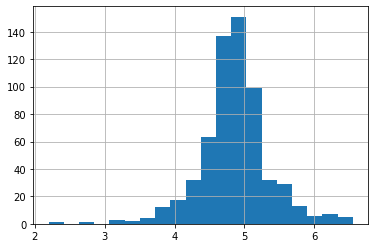

In [20]:
#Since an ML algorithm performs poorly with outliers, appending log transformed feature to counter the skewness

train_data['LoanAmount_logged'] = np.log(train_data['LoanAmount'])
train_data['LoanAmount_logged'].hist(bins=20)
test_data['LoanAmount_logged'] = np.log(test_data['LoanAmount'])

In [21]:
#Now lets split the input feature and output label into separate variables for training

y = train_data.Loan_Status
X = train_data.drop('Loan_Status',axis = 1)

In [22]:
#Converting categorical values into numerical ones

X = pd.get_dummies(X)
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

## Based on the domain knowledge, we can create more useful features!

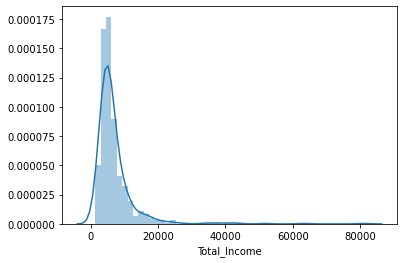

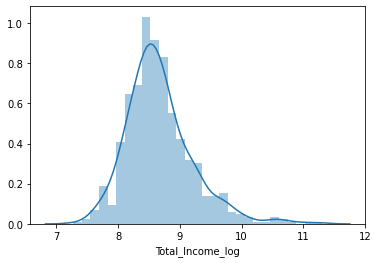

In [23]:
train_data['Total_Income'] = train_data['ApplicantIncome'] + train_data['CoapplicantIncome']
test_data['Total_Income'] = test_data['ApplicantIncome'] + test_data['CoapplicantIncome']
sns.distplot(train_data['Total_Income'])
plt.show()
#As it is skewed, let us normalize it with log transform
train_data['Total_Income_log'] = np.log(train_data['Total_Income'])
test_data['Total_Income_log'] = np.log(test_data['Total_Income'])
sns.distplot(train_data['Total_Income_log'])
plt.show()

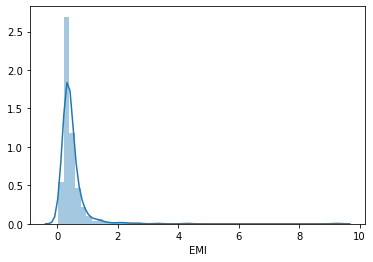

In [24]:
train_data['EMI'] = train_data['LoanAmount']/train_data['Loan_Amount_Term']
test_data['EMI'] = test_data['LoanAmount']/test_data['Loan_Amount_Term']
sns.distplot(train_data['EMI'])
plt.show()

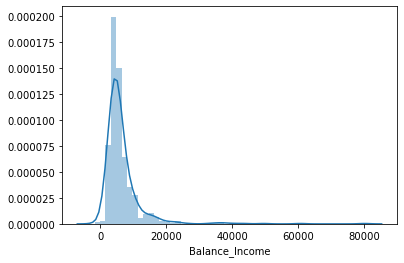

In [25]:
train_data['Balance_Income'] = train_data['Total_Income'] - (train_data['EMI']*1000)
test_data['Balance_Income'] = test_data['Total_Income'] - (test_data['EMI']*1000)
sns.distplot(train_data['Balance_Income'])
plt.show()

In [26]:
#Now that we have derived these features, we can remove the original ones to reduce noise and redundancy
train_data = train_data.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis = 1)
test_data = test_data.drop(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term'], axis = 1)

In [27]:
#Splitting the training samples for training and validation
x_train, x_cv, y_train, y_cv = train_test_split(X, y, test_size = 0.3)

#Running K Fold Validation
kf = kfold(n_splits = 5, random_state = 1, shuffle = True)
for train_index, test_index in kf.split(X, y):
    xtr, xvl = X.loc[train_index], X.loc[test_index]
    ytr, yvl = y.loc[train_index], y.loc[test_index]
#Rescaling the features to normalize their scales
xt_scaled = scale(xtr)
xv_scaled = scale(xvl)
test_data_scaled = scale(test_data)

#Performing Grid Search to find the parameters
parameters =  {'penalty': ['l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
clf = logi()
#clf = GridSearchCV(logi(), parameters)

clf.fit(xt_scaled, ytr)
pred = clf.predict(xv_scaled)
print(metrics.accuracy_score(pred, yvl))

0.7950819672131147


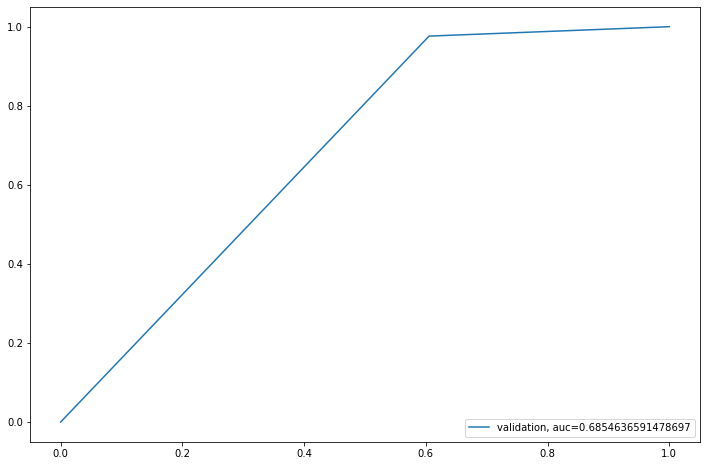

In [28]:
#Evaluating the performance of the model using ROC curve and AUC metric
fpr, tpr, _ = metrics.roc_curve(yvl, pred)
auc = metrics.roc_auc_score(yvl, pred)
plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, label = "validation, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [29]:
pred_test = clf.predict(test_data_scaled)

submission = pd.read_csv("sample_submission_49d68Cx.csv")
submission['Loan_Status'] = pred_test
submission['Loan_ID'] = test_ID
submission['Loan_Status'].replace(1, 'Y', inplace=True)
submission['Loan_Status'].replace(0, 'N', inplace=True)

pd.DataFrame(submission, columns = ['Loan_ID', 'Loan_Status']).to_csv('logistic.csv', index = False)